In [10]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch
import torch.autograd
from torch.optim import AdamW, SGD, Adam
import torch.nn

import random
import stim
import stim_model
import cpn_model


# We will recapitulate sine waves with various starting
# phases. 'steps' is the trial length
steps = 200
batch_size = 256
# y=target, x=phase
target = torch.zeros((batch_size, steps, 2))
for bidx in range(batch_size):
    offset = bidx / float(batch_size)
    for i in range(steps):
        t = torch.tensor(6 * (i / 100.0) + offset)
        target[bidx, i, 0] = torch.sin(t)
        target[bidx, i, 1] = t
        
target = target[torch.randperm(target.shape[0]), :, :]

# A 'Thing' is the thing we are stimulating. It is basically
# a single variable diffeq-goverened system that merely dampens
# over time, except a stimulation can excite it.
class Thing(object):
    def __init__(self, init=0.0, decay=0.7):
        assert isinstance(init, float)
        self.x = init
        self.decay = decay

    def observe(self):
        return self.x

    def step(self, input):
        assert isinstance(input, float)
        self.x += input
        self.x = self.decay * self.x
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Alternate, more difficult problem that involves memory.
# Learning isn't working here yet.
# We will recapitulate sine waves with various starting
# frequencies. 'steps' is the trial length
steps = 200
show_steps = 35
hold_steps = 70
batch_size = 256
# y=target, x=(target freq, hold signal)
target = torch.zeros((batch_size, steps, 3))
for bidx in range(batch_size):
    freq = bidx * 4 / float(batch_size) + 2
    for i in range(steps):     
        # This is a harder problem involving memory, which looks
        # a lot like the the Michaels problem
        # Dim 1: the target value
        if i < hold_steps:
            target[bidx, i, 0] = 0.0
        else:
            t = torch.tensor(freq * ((i - hold_steps)/ 100.0))
            target[bidx, i, 0] = torch.sin(t)
        
        # Dim 2: the target freq
        if i < show_steps:
            target[bidx, i, 1] = torch.tensor(freq)
        else:
            target[bidx, i, 1] = 0.0
            
        # Dim 3: the hold signal
        if i < hold_steps:
            target[bidx, i, 2] = 1.0
        else:
            target[bidx, i, 2] = 0.0

target = target[torch.randperm(target.shape[0]), :, :]

In [11]:
# Train a BEN on a collection of CPNs, centered at the given CPN,
#  with mean 0 noise added to the weights.

      
def make_noised_cpn(cpn, var=0.1):
    cpn_out = cpn_model.CPNModel(cpn.in_dim, cpn.out_dim, num_neurons=cpn.num_neurons,
                                 activation_func=cpn.activation_func_t)
    cpn_out.load_state_dict(cpn.state_dict())
    
    with torch.no_grad():
        for p in cpn_out.parameters():
            noise = var * (torch.rand(p.shape) - 0.5)
            p.data = p.data + p.data * noise
            
    return cpn_out

def train_a_ben(cpn, ben=None, last_loss=1):
    global recent_ben
    
    # An observation of a 1 dimensional thing, 1 dimension of stimulation, 1 dimension 'x'
    if ben is None or last_loss > 0.05:
        ben = stim_model.StimModel(target.shape[-1] + 1, 1, num_neurons=10, activation_func=torch.nn.Tanh)
        recent_ben = ben
    vl = torch.ones(1)
    opt_ben = AdamW(ben.parameters(), lr=1e-3, weight_decay=0.02)
    loss = torch.nn.MSELoss()

    checkpoint_eidx = 0
    for eidx in range(10000000):
        ben.reset()
        opt_ben.zero_grad()
        all_obs = torch.zeros(batch_size, steps, requires_grad=False)
        preds = torch.zeros(batch_size, steps)
        cpn.reset()
        
        for p in opt_ben.param_groups:
            if eidx < 3:
                p['lr'] = 5e-3
            else:
                p['lr'] = min(max(1e-4, 0.4192 * vl.item()), 3e-3)
    
        random_targets = target[torch.randperm(target.shape[0]), :, :]
        cpn_noise = cpn_model.CPNNoiseyCollection(cpn, noise_var=(0.4 * last_loss))
        # Just in case...
        for param in cpn_noise.parameters():
            param.requires_grad=False
            
        things = [Thing(init=x.item()) for x in random_targets[:, 0, 0]]
        s = stim.StimulusGaussianExp(1, 1, batch_size=batch_size, pad_right_neurons=1)
        for tidx in range(steps):
            obs = [t.observe() for t in things]
            new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
            all_obs[:, tidx:tidx+1] = new_obs
          
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn_noise(cpn_in)
        
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            preds[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            n = s.get_next().detach().numpy()

            for bidx in range(batch_size):
                things[bidx].step(n[bidx, 0].item())
        
        rl = loss(preds, all_obs)
        rl.backward()
        opt_ben.step()
        
        # Verify against the actual CPN
        things = [Thing(init=x.item()) for x in random_targets[:, 0, 0]]
        s = stim.StimulusGaussianExp(1, 1, batch_size=batch_size, pad_right_neurons=1)
        obs_val = torch.zeros(batch_size, steps)
        preds_val = torch.zeros(batch_size, steps)
        cpn.reset()
        ben.reset()
        for tidx in range(steps):
            obs = [t.observe() for t in things]
            new_obs = torch.tensor(obs).reshape(256,1)
            obs_val[:, tidx:tidx+1] = new_obs
          
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn(cpn_in)
        
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            preds_val[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            n = s.get_next().detach().numpy()

            obs = []
            for bidx in range(batch_size):
                things[bidx].step(n[bidx, 0].item())
        
        vl = loss(preds_val, obs_val)
        print("ben", eidx, rl.item(), "first 80:",
              loss(preds[:80, :], all_obs[:80, :]).item(),
              "val:", vl.item())
        if torch.isnan(vl) or torch.isinf(vl) or vl.item() > 0.5 or (eidx - checkpoint_eidx) > 5000:
            # Emergency eject button
            ben = stim_model.StimModel(ben.in_dim, ben.out_dim, num_neurons=ben.num_neurons,
                                       activation_func=ben.activation_func_t)
            recent_ben = ben
            opt_ben = AdamW(ben.parameters(), lr=1e-3, weight_decay=0.02)
            checkpoint_eidx = eidx
            
        if vl.item() < max(0.01 * last_loss, 0.0007) and eidx > 200:
            break
            
    return ben

cpn 0 0.3833499848842621 0.07269547134637833 0.4138767123222351


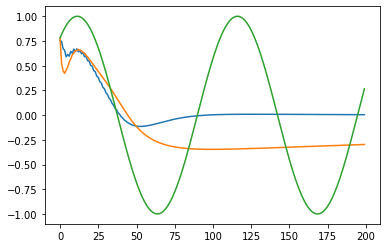

In [25]:
# @preston: this is the core learning algorithm, and seems to be
# able to converge if the problem is structured in a sane way.
#
# In essence: this training loop trains until the (B)EN reaches a
#  certain threshold of loss on the untrained CPN. This can take
#  awhile to converge. Once it does, the CPN will be trained. The
#  BEN is then retrained until it converges again. That way: we only
#  ever train the CPN on an 'accurate' BEN.
#
# Adding the "label" input, which is the second column in target, is
# necessary. Alternatively once could start every trial at the same
# phase - basically memorizing one exact sine wave.


#  1 dimension of stim param, output
#cpn = cpn_model.CPNModel(target.shape[-1], 1, num_neurons=10, activation_func=torch.nn.Tanh)

loss = torch.nn.MSELoss()
#opt_cpn = AdamW(cpn.parameters(), lr=2e-3)

rli = 1

ben_losses = []
cpn_losses = []
bens = []
ben = recent_ben
while True:

    for param in cpn.parameters():
        param.requires_grad=False
    # @preston: retraining an existing ben doesn't work - it never converges.
    #ben = train_a_ben(cpn, ben=ben, last_loss=rli)
    #ben = train_a_ben(cpn, last_loss=rli)
    bens.append(ben)
    for param in cpn.parameters():
        param.requires_grad=True
    for param in ben.parameters():
        param.requires_grad=False
        
    recent_losses = []
    for eidx in range(100):
        cpn.reset()
        ben.reset()
        opt_cpn.zero_grad()
    
        thing = [Thing(init=x.item()) for x in target[:, 0, 0].detach().numpy()]
    
        pred = torch.zeros((256, steps))
        # This is actually very simple in our single variable context: it outputs
        # a stimulation value which decays to 0 over time.
        # The 'padding' is a cludgy, ugly thing that you can ignore; it's for
        #  the purpose of applying to the Michaels model. I may remove it later.
        s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
    
        all_obs = torch.zeros(256, steps)
        stims = []

        for tidx in range(steps):
            obs = [t.observe() for t in thing]
            new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
            all_obs[:, tidx:tidx+1] = new_obs
          
            x = target[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn(cpn_in)
            new_stim.retain_grad()
        
            x = target[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            pred[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            stims.append(new_stim)
            n = s.get_next().detach().numpy()

            for bidx in range(batch_size):
                thing[bidx].step(n[bidx, 0].item())

            
        rl = loss(pred, target[:, :, 0])
        rli = rl.item()
        rl.backward()  

        real_loss = loss(all_obs, target[:, :, 0])
        print("cpn", eidx, rl.item(), loss(pred, all_obs).item(), real_loss.item())
        recent_losses.append(real_loss)
        
        break
                        
        # Emergency bailout; time to retrain ben
        if len(recent_losses) > 12 and (recent_losses[-1] > recent_losses[0] * 1.2):
            ben = None
            break
        # Done
        elif rli < 0.003:
            break
        elif len(recent_losses) > 12:
            prev = None
            num_regressed = 0
            for l in recent_losses[-12:]:
                if prev is not None and l > prev:
                    num_regressed += 1
                        
                prev = l
            
            if num_regressed > 3 and loss(pred, all_obs).item() > rli or num_regressed > 5:
                if eidx < 20:
                    ben = None
              
        cpn_losses.append(rli)
        opt_cpn.step()
        
    break
    if rli < 0.003:
        break

plt.plot(pred[0,:].detach().numpy())
plt.plot(all_obs[0,:].detach().numpy())
plt.plot(target[0, :, 0].detach().numpy())
plt.show()

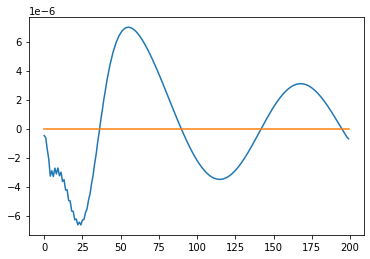

In [27]:
plt.plot([s.grad[0].item() for s in stims])
plt.plot([0.0 for s in stims])

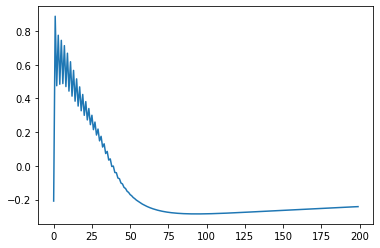

In [26]:
plt.plot([s[0].item() for s in stims])

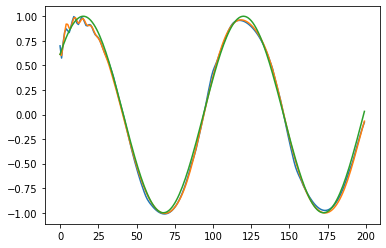

In [433]:
plt.plot(pred[0,:].detach().numpy())
plt.plot(all_obs[0,:].detach().numpy())
plt.plot(target[0,:,0].detach().numpy())
plt.show()

0.051525332033634186


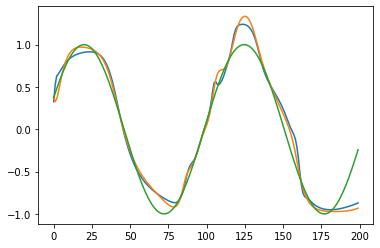

In [491]:
# Check fit of current ben and cpn
ben = recent_ben
cpn.reset()
ben.reset()

stims = []
pred = torch.zeros(batch_size, steps)
all_obs = torch.zeros(batch_size, steps)
noised = make_noised_cpn(cpn)
s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
thing = [Thing(init=x.item()) for x in target[:, 0, 0].detach().numpy()]

#cpn_temp = CPNNoiseyPassthrough(cpn)
for tidx in range(steps):
    obs = [t.observe() for t in thing]
    new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
    all_obs[:, tidx:tidx+1] = new_obs
          
    ind = target[:, tidx, 1].reshape(256,1)
    cpn_in = torch.cat((new_obs, ind), axis=1)
    new_stim = noised(cpn_in)

    ben_in = torch.cat((new_obs, new_stim, ind), axis=1)
    cur_pred = ben(ben_in)
    pred[:, tidx] = cur_pred.squeeze()
        
    s.add(new_stim)
    n = s.get_next().detach().numpy()

    obs = []
    for bidx in range(batch_size):
        thing[bidx].step(n[bidx, 0].item())


loss = torch.nn.MSELoss()
print(loss(pred, target[:, :, 0]).item())
plt.plot(pred[-40, :].detach().numpy())
plt.plot(all_obs[-40, :].detach().numpy())
plt.plot(target[-40, :, 0].detach().numpy())

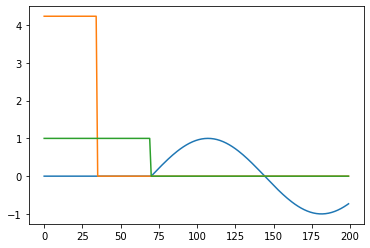

In [4]:
plt.plot(target[-1, :, 0].detach().numpy())
plt.plot(target[-1, :, 1].detach().numpy())
plt.plot(target[-1, :, 2].detach().numpy())